<a href="https://colab.research.google.com/github/davepalaksh/NYC-Parking/blob/main/New%20York%20Parking.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [5]:
!pip install pyspark py4j

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 317.3/317.3 MB 4.9 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for pyspark: filename=pyspark-3.5.3-py2.py3-none-any.whl size=317840625 sha256=e9c65ecbab84b35101a570f51e95fd4235f8b0cddd72048ed34ec057a60ba5a8
  Stored in directory: /root/.cache/pip/wheels/1b/3a/92/28b93e2fbfdbb07509ca4d6f50c5e407f48dce4ddbda69a4ab
Successfully built pyspark


In [6]:
from pyspark.sql import SparkSession
from pyspark.sql.types import *
from pyspark.sql.functions import *
from pyspark.sql.window import Window

In [7]:
spark = SparkSession.builder.appName("NYC").getOrCreate()

In [8]:
from google.colab import drive
drive.mount('/content/drive')


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [51]:
# reading the csv file
df=spark.read.format("csv").option("header","True").option("inferSchema","true").load("/content/drive/MyDrive/Parking_Violations_Issued_-_Fiscal_Year_2017.csv")

In [52]:
df.printSchema()

root
 |-- Summons Number: long (nullable = true)
 |-- Plate ID: string (nullable = true)
 |-- Registration State: string (nullable = true)
 |-- Plate Type: string (nullable = true)
 |-- Issue Date: string (nullable = true)
 |-- Violation Code: integer (nullable = true)
 |-- Vehicle Body Type: string (nullable = true)
 |-- Vehicle Make: string (nullable = true)
 |-- Issuing Agency: string (nullable = true)
 |-- Street Code1: integer (nullable = true)
 |-- Street Code2: integer (nullable = true)
 |-- Street Code3: integer (nullable = true)
 |-- Vehicle Expiration Date: integer (nullable = true)
 |-- Violation Location: integer (nullable = true)
 |-- Violation Precinct: integer (nullable = true)
 |-- Issuer Precinct: integer (nullable = true)
 |-- Issuer Code: integer (nullable = true)
 |-- Issuer Command: string (nullable = true)
 |-- Issuer Squad: string (nullable = true)
 |-- Violation Time: string (nullable = true)
 |-- Time First Observed: string (nullable = true)
 |-- Violation Coun

In [53]:
columns_todrop=['Issuing Agency',
 'Plate Type',
 'Street Code1',
 'Street Code2',
 'Street Code3',
 'Vehicle Expiration Date',
 'Violation Location',
 'Issuer Code',
 'Issuer Command',
 'Issuer Squad',
 'Time First Observed',
 'Violation County',
 'Violation In Front Of Or Opposite',
 'House Number',
 'Street Name',
 'Intersecting Street',
 'Date First Observed',
 'Law Section',
 'Sub Division',
 'Violation Legal Code',
 'Days Parking In Effect    ',
 'From Hours In Effect',
 'To Hours In Effect',
 'Vehicle Color',
 'Unregistered Vehicle?',
 'Vehicle Year',
 'Meter Number',
 'Feet From Curb',
 'Violation Post Code',
 'Violation Description',
 'No Standing or Stopping Violation',
 'Hydrant Violation',
 'Double Parking Violation']

In [54]:
df=df.drop(*columns_todrop)

In [55]:
df.columns

['Summons Number',
 'Plate ID',
 'Registration State',
 'Issue Date',
 'Violation Code',
 'Vehicle Body Type',
 'Vehicle Make',
 'Violation Precinct',
 'Issuer Precinct',
 'Violation Time']

In [56]:
len(df.columns)

10

In [57]:
df.show(5)

+--------------+--------+------------------+----------+--------------+-----------------+------------+------------------+---------------+--------------+
|Summons Number|Plate ID|Registration State|Issue Date|Violation Code|Vehicle Body Type|Vehicle Make|Violation Precinct|Issuer Precinct|Violation Time|
+--------------+--------+------------------+----------+--------------+-----------------+------------+------------------+---------------+--------------+
|    5092469481| GZH7067|                NY|07/10/2016|             7|             SUBN|       TOYOT|                 0|              0|         0143A|
|    5092451658| GZH7067|                NY|07/08/2016|             7|             SUBN|       TOYOT|                 0|              0|         0400P|
|    4006265037| FZX9232|                NY|08/23/2016|             5|             SUBN|        FORD|                 0|              0|         0233P|
|    8478629828| 66623ME|                NY|06/14/2017|            47|             REFG|

In [58]:
#changing the names of columns adding '_'

df=df.toDF(*(colName.replace(' ','_') for colName in df.columns))
df.show(5)

+--------------+--------+------------------+----------+--------------+-----------------+------------+------------------+---------------+--------------+
|Summons_Number|Plate_ID|Registration_State|Issue_Date|Violation_Code|Vehicle_Body_Type|Vehicle_Make|Violation_Precinct|Issuer_Precinct|Violation_Time|
+--------------+--------+------------------+----------+--------------+-----------------+------------+------------------+---------------+--------------+
|    5092469481| GZH7067|                NY|07/10/2016|             7|             SUBN|       TOYOT|                 0|              0|         0143A|
|    5092451658| GZH7067|                NY|07/08/2016|             7|             SUBN|       TOYOT|                 0|              0|         0400P|
|    4006265037| FZX9232|                NY|08/23/2016|             5|             SUBN|        FORD|                 0|              0|         0233P|
|    8478629828| 66623ME|                NY|06/14/2017|            47|             REFG|

In [59]:
df.count()

10803028

In [61]:
#handling null values

print('Null Values before dropping are',df.count() )

df=df.na.drop()

print('Null Values after dropping are', df.count())

Null Values before dropping are 10698175
Null Values after dropping are 10698175


**STEP 1: HANDLING NULL VALUES**

In [62]:
# Drop duplicate values based on the summons number column

# Check the count before dropping duplicate summon numbers
print('Count before dropping duplicate summon numbers : ', df.count())

# drop duplicate summon numbers
df.select('Summons_Number').dropDuplicates()

# Check the count after dropping duplicate summon numbers
print('Count before dropping duplicate summon numbers : ', df.count())

Count before dropping duplicate summon numbers :  10698175
Count before dropping duplicate summon numbers :  10698175


In [63]:
df.show(5)

+--------------+--------+------------------+----------+--------------+-----------------+------------+------------------+---------------+--------------+
|Summons_Number|Plate_ID|Registration_State|Issue_Date|Violation_Code|Vehicle_Body_Type|Vehicle_Make|Violation_Precinct|Issuer_Precinct|Violation_Time|
+--------------+--------+------------------+----------+--------------+-----------------+------------+------------------+---------------+--------------+
|    5092469481| GZH7067|                NY|07/10/2016|             7|             SUBN|       TOYOT|                 0|              0|         0143A|
|    5092451658| GZH7067|                NY|07/08/2016|             7|             SUBN|       TOYOT|                 0|              0|         0400P|
|    4006265037| FZX9232|                NY|08/23/2016|             5|             SUBN|        FORD|                 0|              0|         0233P|
|    8478629828| 66623ME|                NY|06/14/2017|            47|             REFG|

**STEP 2 : Creating a Temp Table**

In [64]:
#creating a temporary table

df.createOrReplaceTempView('Parking')

In [65]:
spark.sql('select * from Parking')

DataFrame[Summons_Number: bigint, Plate_ID: string, Registration_State: string, Issue_Date: string, Violation_Code: int, Vehicle_Body_Type: string, Vehicle_Make: string, Violation_Precinct: int, Issuer_Precinct: int, Violation_Time: string]

**Step 3 : Data Cleaning and Data Preparation**

Let us first filter the data for the year 2017 and create a new table with that data

In [66]:
# Find the total number of tickets for each year

year_wise_tickets = spark.sql("select year(Issue_Date) as year, count(Summons_Number) as no_of_tickets from parking \
                              group by year order by year desc")

year_wise_tickets.show(70)

+----+-------------+
|year|no_of_tickets|
+----+-------------+
|NULL|     10698175|
+----+-------------+



In [67]:
# Filter out only 2017 related data

parking2017 = spark.sql("select * from parking \
                         where year(to_date(cast(unix_timestamp(Issue_Date,'MM/dd/yyyy') as timestamp))) = 2017")

parking2017.count()

5379170

In [69]:
# Create a new temp table with the 2017 data.

parking2017.createOrReplaceTempView("parking_2017")

In [70]:
spark.sql("select count(distinct Summons_Number) as summons_count from parking_2017").show()

+-------------+
|summons_count|
+-------------+
|      5379170|
+-------------+



Check the Plate Id for any erroneous data and if exists remove the erroneous data

In [71]:
# Check the tickets issued based on plate ids

check_plate_id = spark.sql("select Plate_ID as plate_id, count(*) as ticket_count \
                          from parking_2017 \
                          group by plate_id \
                          having count(*) > 1 \
                          order by ticket_count desc")

check_plate_id.show()

+----------+------------+
|  plate_id|ticket_count|
+----------+------------+
|BLANKPLATE|        3378|
|   94905JA|         524|
|   14828MJ|         518|
|   96087MA|         508|
|   2121796|         505|
|   96089MA|         504|
|   85848MD|         499|
|   16242TC|         495|
|   47603MD|         490|
|   30954JX|         489|
|   77116MA|         489|
|   2194153|         487|
|   12359MG|         472|
|   16208TC|         464|
|   49731MA|         460|
|    XEEF98|         456|
|   14829MJ|         455|
|   2028685|         452|
|   49331KA|         451|
|   66103JR|         451|
+----------+------------+
only showing top 20 rows



In [72]:
# Remove the rows containing value as BLANKPLATE for plate_id

parking2017 = parking2017[parking2017.Plate_ID != 'BLANKPLATE']
parking2017.count()

5375792

In [73]:
parking2017.createOrReplaceTempView("parking_2017")

In [74]:
# Check the count now

spark.sql("select count(*) as count FROM parking_2017").show()

+-------+
|  count|
+-------+
|5375792|
+-------+



Check the Registered State for any erroneous data and if exists replace the erroneous data with a valid data

In [75]:
# Check the ticket counts based in registered state

registered_state_wise_tickets = spark.sql("select Registration_State as registration_state, count(*) as ticket_count \
                               from parking_2017 \
                               group by registration_state \
                               order by ticket_count desc")

registered_state_wise_tickets.show(70)

+------------------+------------+
|registration_state|ticket_count|
+------------------+------------+
|                NY|     4244706|
|                NJ|      470390|
|                PA|      138323|
|                CT|       69624|
|                FL|       68626|
|                IN|       44860|
|                MA|       38253|
|                VA|       33961|
|                MD|       29956|
|                NC|       26820|
|                TX|       18585|
|                IL|       18182|
|                GA|       17346|
|                AZ|       12180|
|                OH|       12137|
|                CA|       11985|
|                SC|       10302|
|                MN|        9709|
|                OK|        8816|
|                99|        8740|
|                ME|        8184|
|                DE|        7778|
|                TN|        7297|
|                MI|        7128|
|                RI|        5153|
|                NH|        4073|
|             

In [76]:

spark.sql("select count(distinct Registration_State) as count from parking_2017").show()

+-----+
|count|
+-----+
|   65|
+-----+



In [77]:
# Replace the state named 99 with NY, as NY has the maximum violations.

from pyspark.sql.functions import when,lit

parking2017 = parking2017.withColumn('Registration_State', \
                                     when(parking2017["Registration_State"] == "99", lit('NY'))\
                                     .otherwise(parking2017["Registration_State"]))

In [78]:
# update the temp table with the current data

parking2017.createOrReplaceTempView("parking_2017")

In [79]:
# Check the ticket counts based on registered state again and see if 10794 rows associated to state 99 has been now added to
# NY (4273951 + 10794 = 4284745)

registered_state_wise_tickets = spark.sql("select Registration_State as registration_state, count(*) as ticket_count \
                               from parking_2017 \
                               group by registration_state \
                               order by ticket_count desc")

registered_state_wise_tickets.show(70)

+------------------+------------+
|registration_state|ticket_count|
+------------------+------------+
|                NY|     4253446|
|                NJ|      470390|
|                PA|      138323|
|                CT|       69624|
|                FL|       68626|
|                IN|       44860|
|                MA|       38253|
|                VA|       33961|
|                MD|       29956|
|                NC|       26820|
|                TX|       18585|
|                IL|       18182|
|                GA|       17346|
|                AZ|       12180|
|                OH|       12137|
|                CA|       11985|
|                SC|       10302|
|                MN|        9709|
|                OK|        8816|
|                ME|        8184|
|                DE|        7778|
|                TN|        7297|
|                MI|        7128|
|                RI|        5153|
|                NH|        4073|
|                VT|        3642|
|             

In [80]:
# Count of distinct Registration states

spark.sql("select count(distinct Registration_State) as count from parking_2017").show()

+-----+
|count|
+-----+
|   64|
+-----+



**Basic Data Analysis**

In [81]:
# Let us check which month in the year 2017 has maximum summons

month_wise_tickets = spark.sql("select month(Issue_Date) as month, count(*) as ticket_count \
                               from parking_2017 \
                               group by month(Issue_Date) \
                               order by ticket_count desc")

month_wise_tickets.show()

+-----+------------+
|month|ticket_count|
+-----+------------+
| NULL|     5375792|
+-----+------------+



Top 5 states that have maximum violations

<Figure size 640x480 with 0 Axes>

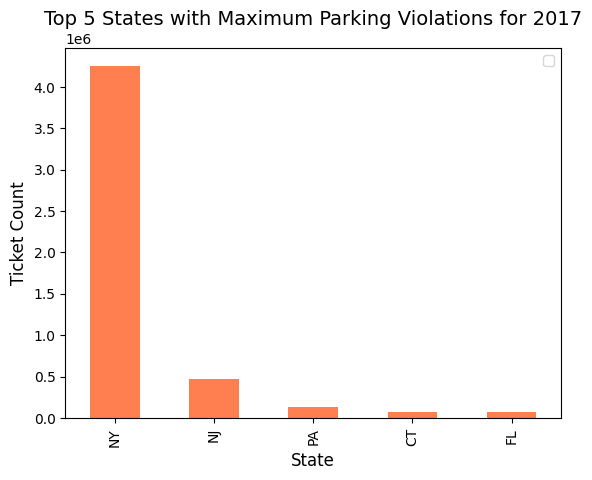

In [85]:
# create a dataframe with the ragistered state wise tickets

import matplotlib.pyplot as plt
registered_state_wise_tickets_df = registered_state_wise_tickets.toPandas()

# plot a graph
plt.clf()
registered_state_wise_tickets_df.head(5).plot(x='registration_state', y='ticket_count', kind='bar', color ='coral')
plt.title('Top 5 States with Maximum Parking Violations for 2017', fontsize = 14)
plt.xlabel("State", fontsize = 12)
plt.ylabel("Ticket Count", fontsize = 12)
plt.legend('')
plt.show()

Top 5 Plate_Ids that have maximum violations

In [88]:
# Top 5 Plate Ids with maximum violations

top_5_plate_ids = spark.sql("select Plate_ID as plate_id, count(*) as ticket_count \
                             from parking_2017 \
                             group by plate_id \
                             order by ticket_count desc \
                             limit 5")
top_5_plate_ids.show()

+--------+------------+
|plate_id|ticket_count|
+--------+------------+
| 94905JA|         524|
| 14828MJ|         518|
| 96087MA|         508|
| 2121796|         505|
| 96089MA|         504|
+--------+------------+



<Figure size 640x480 with 0 Axes>

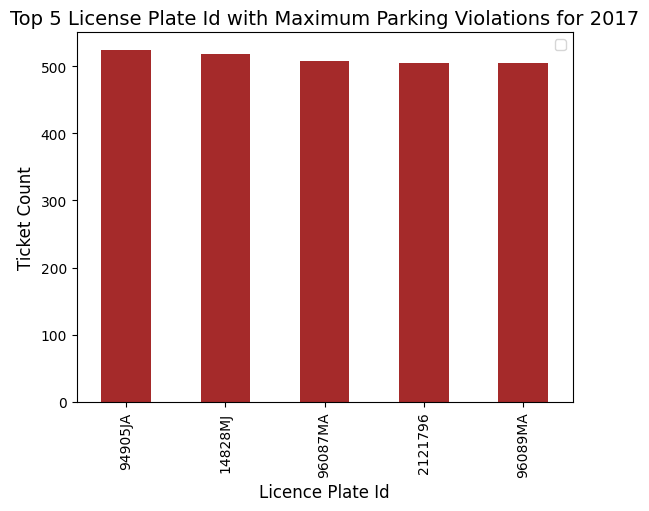

In [89]:
# create a dataframe with the month wise tickets data

top_5_plate_ids_df = top_5_plate_ids.toPandas()

# plot a graph
plt.clf()
top_5_plate_ids_df.plot(x='plate_id', y='ticket_count', kind='bar', color='brown')
plt.title("Top 5 License Plate Id with Maximum Parking Violations for 2017", fontsize = 14)
plt.xlabel("Licence Plate Id", fontsize = 12)
plt.ylabel("Ticket Count", fontsize = 12)
plt.legend('')
plt.show()

Find the total number of tickets for the year.

In [90]:
# Total number of tickets for the year 2017

from pyspark.sql.functions import countDistinct
parking2017.select(countDistinct("Summons_Number").alias("total_number_of_tickets")).show()

+-----------------------+
|total_number_of_tickets|
+-----------------------+
|                5375792|
+-----------------------+



**Aggregation Tasks**

How often does each violation code occur? Display the frequency of the top five violation codes.

In [91]:
# How often does each violation code occur? Display the frequency of the top five violation codes

violation_code_frequency = spark.sql("select Violation_Code as violation_code, count(*) as ticket_frequency \
                                      from parking_2017 \
                                      group by violation_code \
                                      order by ticket_frequency desc \
                                      limit 5")
violation_code_frequency.show()

+--------------+----------------+
|violation_code|ticket_frequency|
+--------------+----------------+
|            21|          759588|
|            36|          661827|
|            38|          540060|
|            14|          472140|
|            20|          317546|
+--------------+----------------+



<Figure size 640x480 with 0 Axes>

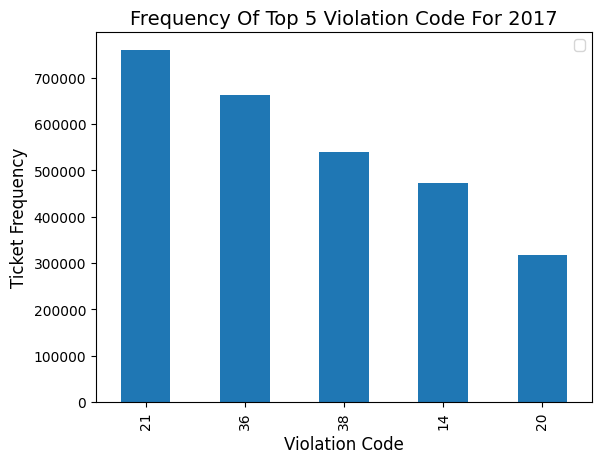

In [92]:
# create a dataframe with the violation_code_frequency

violation_code_frequency_df = violation_code_frequency.toPandas()

# plot a graph
plt.clf()
violation_code_frequency_df.plot(x='violation_code', y='ticket_frequency', kind='bar')
plt.title('Frequency Of Top 5 Violation Code For 2017', fontsize = 14)
plt.xlabel("Violation Code", fontsize = 12)
plt.ylabel("Ticket Frequency", fontsize = 12)
plt.legend('')
plt.show()

How often does each 'vehicle body type' get a parking ticket? How about the 'vehicle make'? (Hint: Find the top 5 for both.)

In [93]:
# Display the frequency of the top five Vehicle Body Type getting a parking ticket

vehicle_body_type_frequency = spark.sql("select Vehicle_Body_Type as vehicle_body_type, count(*) as ticket_frequency \
                                      from parking_2017 \
                                      group by vehicle_body_type \
                                      order by ticket_frequency desc \
                                      limit 5")

vehicle_body_type_frequency.show()

+-----------------+----------------+
|vehicle_body_type|ticket_frequency|
+-----------------+----------------+
|             SUBN|         1879871|
|             4DSD|         1546800|
|              VAN|          718670|
|             DELV|          351825|
|              SDN|          189114|
+-----------------+----------------+



<Figure size 640x480 with 0 Axes>

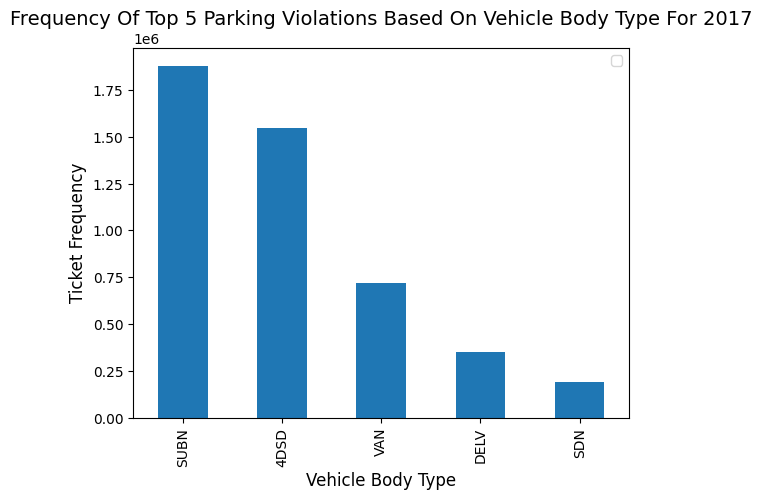

In [94]:
# create a dataframe with the vehicle_body_type_frequency

vehicle_body_type_frequency_df = vehicle_body_type_frequency.toPandas()

# plot a graph
plt.clf()
vehicle_body_type_frequency_df.head(5).plot(x='vehicle_body_type', y='ticket_frequency', kind='bar')
plt.title('Frequency Of Top 5 Parking Violations Based On Vehicle Body Type For 2017', fontsize = 14)
plt.xlabel("Vehicle Body Type", fontsize = 12)
plt.ylabel("Ticket Frequency", fontsize = 12)
plt.legend('')
plt.show()

In [95]:
# Display the frequency of the top five Vehicle Make getting a parking ticket

vehicle_make_ticket_frequency = spark.sql("select Vehicle_Make as vehicle_make, count(*) as ticket_frequency \
                                          from parking_2017 \
                                          group by vehicle_make \
                                          order by ticket_frequency desc \
                                          limit 5")
vehicle_make_ticket_frequency.show()

+------------+----------------+
|vehicle_make|ticket_frequency|
+------------+----------------+
|        FORD|          635062|
|       TOYOT|          603838|
|       HONDA|          537252|
|       NISSA|          460675|
|       CHEVR|          355122|
+------------+----------------+



<Figure size 640x480 with 0 Axes>

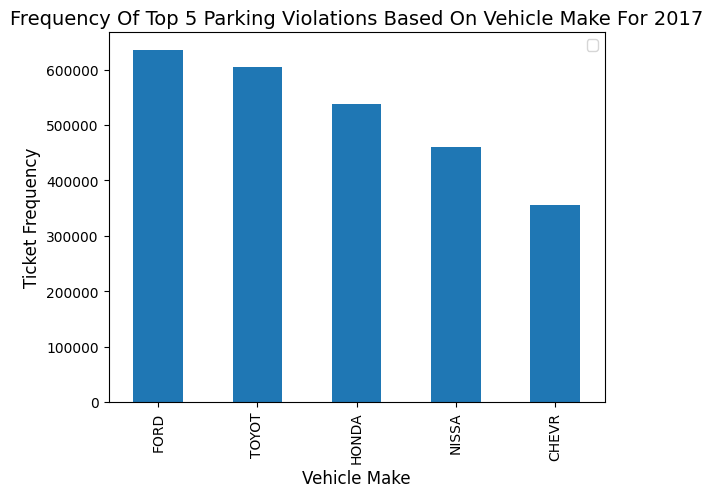

In [96]:
# create a dataframe with the vehicle_make_ticket_frequency
vehicle_make_ticket_frequency_df = vehicle_make_ticket_frequency.toPandas()

# plot a graph
plt.clf()
vehicle_make_ticket_frequency_df.plot(x='vehicle_make', y='ticket_frequency', kind='bar')
plt.title('Frequency Of Top 5 Parking Violations Based On Vehicle Make For 2017', fontsize = 14)
plt.xlabel("Vehicle Make", fontsize = 12)
plt.ylabel("Ticket Frequency", fontsize = 12)
plt.legend('')
plt.show()

Per the results from above, it can be inferred that - For Vehical Body Type, maximum parking violations happen for Suburban(SUBN) followed by four door sedan(4DSD) and Van - For Vehicle Make, maximum parking violations happen for Ford follwed by Toyota and Honda

In [ ]:
#--

**A precinct is a police station that has a certain zone of the city under its command. Find the (5 highest) frequencies of tickets for each of the following :
'Violation Precinct' (This is the precinct of the zone where the violation occurred). Using this, can you draw any insights for parking violations in any specific areas of the city?
'Issuer Precinct' (This is the precinct that issued the ticket.)**
Here, you would have noticed that the dataframe has the'Violating Precinct' or 'Issuing Precinct' as '0'. These are erroneous entries. Hence, you need to provide the records for five correct precincts. (Hint: Print the top six entries after sorting.)

In [97]:
# Display the frequency of the top five violation precinct

violation_precinct_ticket_frequency = spark.sql("select Violation_Precinct as violation_precinct, count(*) as ticket_frequency \
                                                from parking_2017 \
                                                group by violation_precinct \
                                                order by ticket_frequency desc")
violation_precinct_ticket_frequency.show(6)

+------------------+----------------+
|violation_precinct|ticket_frequency|
+------------------+----------------+
|                 0|          923336|
|                19|          272072|
|                14|          200558|
|                 1|          172035|
|                18|          165943|
|               114|          146636|
+------------------+----------------+
only showing top 6 rows



<Figure size 640x480 with 0 Axes>

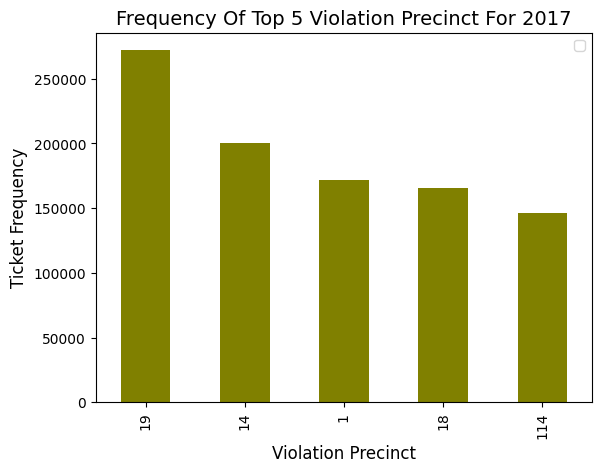

In [98]:

violation_precinct_ticket_frequency_df = violation_precinct_ticket_frequency.toPandas()

# plot a graph
plt.clf()
violation_precinct_ticket_frequency_df[violation_precinct_ticket_frequency_df.violation_precinct != 0].head(5)\
                                        .plot(x='violation_precinct', y='ticket_frequency', kind='bar', color='olive')

plt.title('Frequency Of Top 5 Violation Precinct For 2017', fontsize = 14)
plt.xlabel("Violation Precinct", fontsize = 12)
plt.ylabel("Ticket Frequency", fontsize = 12)
plt.legend('')
plt.show()

In [99]:
# Display the frequency of the top six issuer precinct

issuer_precinct_ticket_frequency = spark.sql("select Issuer_Precinct as issuer_precinct, count(*) as ticket_frequency \
                                                from parking_2017 \
                                                group by issuer_precinct \
                                                order by ticket_frequency desc")

issuer_precinct_ticket_frequency.show(6)

+---------------+----------------+
|issuer_precinct|ticket_frequency|
+---------------+----------------+
|              0|         1063024|
|             19|          264891|
|             14|          197911|
|              1|          166738|
|             18|          160294|
|            114|          143446|
+---------------+----------------+
only showing top 6 rows



<Figure size 640x480 with 0 Axes>

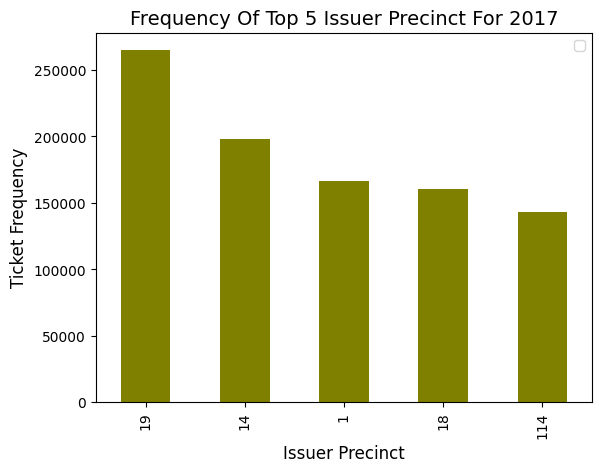

In [100]:
# create a dataframe with the issuer_precinct_ticket_frequency

issuer_precinct_ticket_frequency_df = issuer_precinct_ticket_frequency.toPandas()

# plot a graph
plt.clf()
issuer_precinct_ticket_frequency_df[issuer_precinct_ticket_frequency_df.issuer_precinct != 0].head(5)\
                                        .plot(x='issuer_precinct', y='ticket_frequency', kind='bar', color='olive')

plt.title('Frequency Of Top 5 Issuer Precinct For 2017', fontsize = 14)
plt.xlabel("Issuer Precinct", fontsize = 12)
plt.ylabel("Ticket Frequency", fontsize = 12)
plt.legend('')
plt.show()

Per the results from above, it can be inferred that - The top 3 violation precincts and Issuer Precincts where maximum parking violations happen are 19, 14 and 1

**Find the violation code frequencies for three precincts that have issued the most number of tickets. Do these precinct zones have an exceptionally high frequency of certain violation codes? Are these codes common across precincts?**

In [101]:
# Violation code Frquency for Issuer Precinct 19

violation_code_frequency_precinct19 = spark.sql("select Violation_Code as violation_code, count(*) as ticket_frequency \
                                                from parking_2017 \
                                                where Issuer_Precinct = 19 \
                                                group by violation_code \
                                                order by ticket_frequency desc \
                                                limit 5 ")

violation_code_frequency_precinct19.show()

+--------------+----------------+
|violation_code|ticket_frequency|
+--------------+----------------+
|            46|           47308|
|            38|           36185|
|            37|           36020|
|            14|           29607|
|            21|           28370|
+--------------+----------------+



In [102]:
# Violation code Frquency for Issuer Precinct 14

violation_code_frequency_precinct14 = spark.sql("select Violation_Code as violation_code, count(*) as ticket_frequency \
                                                from parking_2017 \
                                                where Issuer_Precinct = 14 \
                                                group by violation_code \
                                                order by ticket_frequency desc \
                                                limit 5 ")

violation_code_frequency_precinct14.show()

+--------------+----------------+
|violation_code|ticket_frequency|
+--------------+----------------+
|            14|           44520|
|            69|           30196|
|            31|           22481|
|            47|           18305|
|            42|           10009|
+--------------+----------------+



In [103]:
# Common violation Codes across issuer precincts 19, 14 and 1

common_precincts_violation_codes = spark.sql("select Violation_Code as violation_code , count(*) as ticket_frequency \
                                              from parking_2017 \
                                              where Issuer_Precinct in (19, 14, 1) \
                                              group by violation_code \
                                              order by ticket_frequency desc \
                                              limit 5 ")

common_precincts_violation_codes.show()

+--------------+----------------+
|violation_code|ticket_frequency|
+--------------+----------------+
|            14|          112027|
|            46|           67042|
|            38|           47908|
|            37|           43737|
|            69|           38670|
+--------------+----------------+



<Figure size 640x480 with 0 Axes>

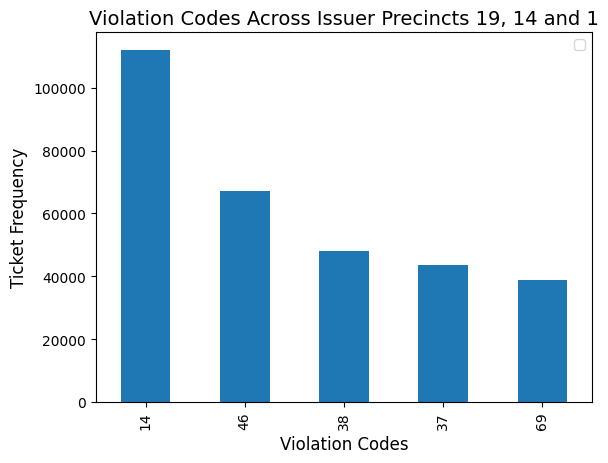

In [104]:

# create a dataframe with the common_precincts_violation_codes

common_precincts_violation_codes_df = common_precincts_violation_codes.toPandas()

# plot a graph
plt.clf()
common_precincts_violation_codes_df.plot(x='violation_code', y='ticket_frequency', kind='bar')
plt.title('Violation Codes Across Issuer Precincts 19, 14 and 1', fontsize = 14)
plt.xlabel("Violation Codes", fontsize = 12)
plt.ylabel("Ticket Frequency", fontsize = 12)
plt.legend('')
plt.show()

The top 3 common violation codes across top 3 precincts 19, 14 and 1 where the parking tickets were issued are 14, 46 and 38.
Violation code 14 has exceptionally high frequency of 1,13,155 tickets issued.
While the violation codes 14, 46 and 38 are common across the issuer precinct, the violation code 14 occurs in all the 3 issuer precincts (19, 14 and 1) while violation codes 46 and 38 occur in issuer precincts 19 and 1

**Find out the properties of parking violations across different times of the day:
- Find a way to deal with missing values, if any.
  (Hint: Check for the null values using 'isNull' under the SQL. Also, to remove the null values, check the 'dropna'
  command in the API documentation.)
- The Violation Time field is specified in a strange format. Find a way to make this a time attribute that you can
  use to divide into groups.
- Divide 24 hours into six equal discrete bins of time. Choose the intervals as you see fit. For each of these
  groups, find the three most commonly occurring violations.
  (Hint: Use the CASE-WHEN in SQL view to segregate into bins. To find the most commonly occurring violations, you
  can use an approach similar to the one mentioned in the hint for question 4.)
- Now, try another direction. For the three most commonly occurring violation codes, find the most common time of
  the day (in terms of the bins from the previous part)**

In [105]:
#Checking for the null value

from pyspark.sql.functions import col
parking2017.where(col("Violation_Time").isNull()).show()

+--------------+--------+------------------+----------+--------------+-----------------+------------+------------------+---------------+--------------+
|Summons_Number|Plate_ID|Registration_State|Issue_Date|Violation_Code|Vehicle_Body_Type|Vehicle_Make|Violation_Precinct|Issuer_Precinct|Violation_Time|
+--------------+--------+------------------+----------+--------------+-----------------+------------+------------------+---------------+--------------+
+--------------+--------+------------------+----------+--------------+-----------------+------------+------------------+---------------+--------------+



**Divide 24 hours into six equal discrete bins of time. Choose the intervals as you see fit. For each of these groups, find the three most commonly occurring violations.**

In [106]:
# Dividing the 24 hours into six equal discrete bins of time.

# We shall divide the 24 hours in the following bin category

#     Bin 1 = 12:00 AM to 4:00 AM
#     Bin 2 = 4:00 AM to 8:00 AM
#     Bin 3 = 8:00 AM to 12:00 PM
#     Bin 4 = 12:00 PM to 4:00 PM
#     Bin 5 = 4:00 PM to 8:00 PM
#     Bin 6 = 8:00 PM to 12:00 AM

violation_time_bins_2017_df = spark.sql("select Summons_Number, Violation_Code, Violation_Time, \
                                         case \
                                               when substring(Violation_Time,1,2) in ('12', '00','01','02','03') \
                                                       and upper(substring(Violation_Time,-1))='A' \
                                               then 1 \
                                               when substring(Violation_Time,1,2) in ('04','05','06','07') \
                                                       and upper(substring(Violation_Time,-1))='A' \
                                               then 2 \
                                               when substring(Violation_Time,1,2) in ('08','09','10','11') \
                                                       and upper(substring(Violation_Time,-1))='A' \
                                               then 3 \
                                               when substring(Violation_Time,1,2) in ('12','00','01','02','03') \
                                                       and upper(substring(Violation_Time,-1))='P' \
                                               then 4 \
                                               when substring(Violation_Time,1,2) in ('04','05','06','07') \
                                                       and upper(substring(Violation_Time,-1))='P' \
                                               then 5 \
                                               when substring(Violation_Time,1,2) in ('08','09','10','11') \
                                                       and upper(substring(Violation_Time,-1))='P' \
                                               then 6 \
                                               else null \
                                        end as Violation_Time_Bin \
                                        from parking_2017 \
                                        where Violation_Time is not null")

violation_time_bins_2017_df.show(10)

+--------------+--------------+--------------+------------------+
|Summons_Number|Violation_Code|Violation_Time|Violation_Time_Bin|
+--------------+--------------+--------------+------------------+
|    8478629828|            47|         1120A|                 3|
|    5096917368|             7|         0852P|                 6|
|    1407740258|            78|         0015A|                 1|
|    1413656420|            40|         0525A|                 2|
|    8480309064|            64|         0256P|                 4|
|    1416638830|            20|         1232A|                 1|
|    4630524241|            36|         1034A|                 3|
|    8505131836|            38|         1021A|                 3|
|    8513520615|            14|         0721A|                 2|
|    8556155431|            75|         0940A|                 3|
+--------------+--------------+--------------+------------------+
only showing top 10 rows



In [107]:
# Create/Replace a Temp View

violation_time_bins_2017_df.createOrReplaceTempView("violation_time_bins_2017")

In [108]:
# Three most commonly occuring violation codes for bin 1 i.e between 12:00 AM to 4:00 AM

violation_time_bin1 = spark.sql("select Violation_Code as violation_code, count(*) as violation_count \
                                 from violation_time_bins_2017 \
                                 where Violation_Time_Bin == 1 \
                                 group by violation_code \
                                 order by violation_count desc \
                                 limit 3 ")
violation_time_bin1.show()

+--------------+---------------+
|violation_code|violation_count|
+--------------+---------------+
|            21|          36117|
|            40|          25313|
|            14|          14978|
+--------------+---------------+



In [109]:
# Three most commonly occuring violation codes for bin 2 i.e between 4:00 AM to 8:00 AM

violation_time_bin2 = spark.sql("select Violation_Code as violation_code, count(*) as violation_count \
                                 from violation_time_bins_2017 \
                                 where Violation_Time_Bin == 2 \
                                 group by violation_code \
                                 order by violation_count desc \
                                 limit 3 ")
violation_time_bin2.show()

+--------------+---------------+
|violation_code|violation_count|
+--------------+---------------+
|            14|          73582|
|            40|          60370|
|            21|          56709|
+--------------+---------------+



In [110]:
# Three most commonly occuring violation codes for bin 3 i.e between 8:00 AM to 12:00 PM

violation_time_bin3 = spark.sql("select Violation_Code as violation_code, count(*) as violation_count \
                                 from violation_time_bins_2017 \
                                 where Violation_Time_Bin == 3 \
                                 group by violation_code \
                                 order by violation_count desc \
                                 limit 3 ")
violation_time_bin3.show()

+--------------+---------------+
|violation_code|violation_count|
+--------------+---------------+
|            21|         592463|
|            36|         347650|
|            38|         175753|
+--------------+---------------+



In [111]:
# Three most commonly occuring violation codes for bin 4 i.e between 12:00 PM to 4:00 PM

violation_time_bin4 = spark.sql("select Violation_Code as violation_code, count(*) as violation_count \
                                 from violation_time_bins_2017 \
                                 where Violation_Time_Bin == 4 \
                                 group by violation_code \
                                 order by violation_count desc \
                                 limit 3 ")
violation_time_bin4.show()

+--------------+---------------+
|violation_code|violation_count|
+--------------+---------------+
|            36|         285895|
|            38|         239881|
|            37|         166794|
+--------------+---------------+



In [112]:
# Three most commonly occuring violation codes for bin 5 i.e between 4:00 PM to 8:00 PM

violation_time_bin5 = spark.sql("select Violation_Code as violation_code, count(*) as violation_count \
                                 from violation_time_bins_2017 \
                                 where Violation_Time_Bin == 5 \
                                 group by violation_code \
                                 order by violation_count desc \
                                 limit 3 ")
violation_time_bin5.show()

+--------------+---------------+
|violation_code|violation_count|
+--------------+---------------+
|            38|         102568|
|            14|          75032|
|            37|          70242|
+--------------+---------------+



In [113]:
# Three most commonly occuring violation codes for bin 6 i.e between 8:00 PM to 12:00 AM

violation_time_bin6 = spark.sql("select Violation_Code as violation_code, count(*) as violation_count \
                                 from violation_time_bins_2017 \
                                 where Violation_Time_Bin == 6 \
                                 group by violation_code \
                                 order by violation_count desc \
                                 limit 3 ")
violation_time_bin6.show()

+--------------+---------------+
|violation_code|violation_count|
+--------------+---------------+
|             7|          26238|
|            40|          22000|
|            14|          20777|
+--------------+---------------+



In [114]:
# Now, Let us find the 3 most commonly occuring violation codes amongst all the 6 bins.

common_violation_codes_across_bins = spark.sql("select Violation_Code as violation_code , count(*) as violation_count \
                                                from violation_time_bins_2017 \
                                                where violation_code in (21, 40, 78, 14, 40, 36, 38, 37, 7) \
                                                and Violation_Time != ''\
                                                group by violation_code \
                                                order by violation_count desc \
                                                limit 3 ")

common_violation_codes_across_bins.show()

+--------------+---------------+
|violation_code|violation_count|
+--------------+---------------+
|            21|         759588|
|            36|         661827|
|            38|         540060|
+--------------+---------------+



From the above results, it can be inferred that - The violation codes that are common across atleast 3 time bins are 21, 38, 14 and 40 - The violation codes that are common across atleast 2 time bins are 36 and 37 - The violation codes that are associated only to 1 time bins are 78 and 7

However, based on the ticket fequency count, the 3 most commonly occuring violation code among all the 6 bins are 21, 36 and 38. Hence we would consider the violation codes 21, 36 and 38 as the most commonly occuring violation codes for our further analysis.

**Now, try another direction. For the three most commonly occurring violation codes, find the most common time of the day (in terms of the bins from the previous part).**

In [115]:
# For the three most commonly occurring violation codes, find the most common time of the day (in terms of the bins from the
# previous part

common_time_for_violation = spark.sql("select Violation_Time_bin as violation_time_bin, count(*) as violation_count \
                                       from violation_time_bins_2017 \
                                       where Violation_Code in (21, 36, 38) \
                                       group by Violation_Time_bin \
                                       order by violation_count desc")
common_time_for_violation.show(6)

+------------------+---------------+
|violation_time_bin|violation_count|
+------------------+---------------+
|                 3|        1115866|
|                 4|         599668|
|                 5|         116292|
|                 2|          72726|
|                 1|          36413|
|                 6|          20485|
+------------------+---------------+
only showing top 6 rows



In [119]:
# First let us divide the year into seasons based on the Issue Date

# We shall divide the 4 seasons based on Issue Date as follows

#     Spring = March to May
#     Summer = June to August
#     Autumn = September to November
#     winter = December to February

seasons2017 = spark.sql("select Summons_Number, Issue_Date, Violation_Code,  \
                        case \
                            when MONTH(TO_DATE(Issue_Date, 'MM/dd/yyyy')) between 03 and 05 \
                                then 'spring' \
                            when MONTH(TO_DATE(Issue_Date, 'MM/dd/yyyy')) between 06 and 08 \
                                then 'summer' \
                            when MONTH(TO_DATE(Issue_Date, 'MM/dd/yyyy')) between 09 and 11 \
                                then 'autumn' \
                            when MONTH(TO_DATE(Issue_Date, 'MM/dd/yyyy')) in (1,2,12) \
                                then 'winter' \
                            else 'unknown' \
                        end as Season \
                        from parking_2017")

seasons2017.show(10)

+--------------+----------+--------------+------+
|Summons_Number|Issue_Date|Violation_Code|Season|
+--------------+----------+--------------+------+
|    8478629828|06/14/2017|            47|summer|
|    5096917368|06/13/2017|             7|summer|
|    1407740258|01/11/2017|            78|winter|
|    1413656420|02/04/2017|            40|winter|
|    8480309064|01/26/2017|            64|winter|
|    1416638830|04/30/2017|            20|spring|
|    4630524241|02/03/2017|            36|winter|
|    8505131836|05/27/2017|            38|spring|
|    8513520615|05/31/2017|            14|spring|
|    8556155431|05/26/2017|            75|spring|
+--------------+----------+--------------+------+
only showing top 10 rows



In [120]:
# Create/Replace a Temp View

seasons2017.createOrReplaceTempView("seasons_2017")

In [121]:
# Frequency of tickets based on season

parking_violations_on_seasons = spark.sql("select Season as season, count(*) as ticket_frequency \
                                           from seasons_2017 \
                                           group by season \
                                           order by ticket_frequency desc")
parking_violations_on_seasons.show()

+------+----------------+
|season|ticket_frequency|
+------+----------------+
|spring|         2841718|
|winter|         1686592|
|summer|          846597|
|autumn|             885|
+------+----------------+



In [122]:
# Three most commonly occuring violation for spring i.e. from March to May

spring = spark.sql("select Violation_Code as violation_code, count(*) as violation_count \
                    from seasons_2017 \
                    where Season == 'spring' \
                    group by violation_code \
                    order by violation_count desc \
                    limit 3 ")
spring.show()

+--------------+---------------+
|violation_code|violation_count|
+--------------+---------------+
|            21|         397739|
|            36|         344366|
|            38|         270030|
+--------------+---------------+



In [123]:
# Three most commonly occuring violation for winter i.e. from December to February

winter = spark.sql("select Violation_Code as violation_code, count(*) as violation_count \
                    from seasons_2017 \
                    where Season == 'winter' \
                    group by violation_code \
                    order by violation_count desc \
                    limit 3 ")
winter.show()

+--------------+---------------+
|violation_code|violation_count|
+--------------+---------------+
|            21|         235365|
|            36|         220956|
|            38|         186833|
+--------------+---------------+



In [124]:
# Three most commonly occuring violation for summer i.e. from June to September

summer = spark.sql("select Violation_Code as violation_code, count(*) as violation_count \
                    from seasons_2017 \
                    where Season == 'summer' \
                    group by violation_code \
                    order by violation_count desc \
                    limit 3 ")
summer.show()

+--------------+---------------+
|violation_code|violation_count|
+--------------+---------------+
|            21|         126366|
|            36|          96505|
|            38|          83190|
+--------------+---------------+



In [125]:
# Three most commonly occuring violation for autumn i.e. from September to November

autumn = spark.sql("select Violation_Code as violation_code, count(*) as violation_count \
                    from seasons_2017 \
                    where Season == 'autumn' \
                    group by violation_code \
                    order by violation_count desc \
                    limit 3 ")
autumn.show()

+--------------+---------------+
|violation_code|violation_count|
+--------------+---------------+
|            46|            203|
|            21|            118|
|            40|            113|
+--------------+---------------+



In [116]:
top_3_common_violations = spark.sql("select Violation_Code as violation_code, count(*) as ticket_frequency \
                                    from parking_2017 \
                                    group by violation_code \
                                    order by ticket_frequency desc \
                                    limit 3")
top_3_common_violations.show()

+--------------+----------------+
|violation_code|ticket_frequency|
+--------------+----------------+
|            21|          759588|
|            36|          661827|
|            38|          540060|
+--------------+----------------+



In [126]:
from pyspark.sql.functions import when

common_violations_fine_amount = top_3_common_violations \
                                .withColumn("fine_amount",when(top_3_common_violations.violation_code == 21, \
                                (top_3_common_violations.ticket_frequency) *55) \
                                .otherwise((top_3_common_violations.ticket_frequency)*50))

common_violations_fine_amount.show()

+--------------+----------------+-----------+
|violation_code|ticket_frequency|fine_amount|
+--------------+----------------+-----------+
|            21|          759588|   41777340|
|            36|          661827|   33091350|
|            38|          540060|   27003000|
+--------------+----------------+-----------+



In [127]:
# Total amount collected for the three violation codes with maximum tickets

from pyspark.sql import functions as F

total = common_violations_fine_amount.agg(F.sum("fine_amount")).collect()
print('Total amount collected for the three violation codes with maximum tickets : ', total)

Total amount collected for the three violation codes with maximum tickets :  [Row(sum(fine_amount)=101871690)]


- Total Number of tickets issued for the year 2017 is 54,26,657.
- May 2017 had the highest parking tickets issued followed by March and April.
- There are 64 unique states where the cars that got parking tickets came from.
- New York has the highest parking violations followed by New Jersey and Pennsylvania.
- Plate Id 96089MA had the maximum parking violations.
- The top 3 violation codes are 21, 36 and 38
    - Code 21 - No parking where parking is not allowed by sign, street marking or traffic control device.
    - Code 36 - Exceeding the posted speed limit in or near a designated school zone.
    - Code 38 - Parking Meter - Failing to show a receipt or tag in the windshield.Drivers get a 5-minute grace period
                past the expired time on parking meter receipts.
- For Vehical Body Type, maximum parking violations happen for Suburban(SUBN) followed by four door sedan(4DSD) and Van
- For Vehicle Make, maximum parking violations happen for Ford follwed by Toyota and Honda
- The top 3 violation precincts and Issuer Precincts where maximum parking violations happen are 19, 14 and 1
- The top 3 violation codes across precincts 19, 14 and 1 where the parking tickets were issued are 14, 46 and 38

- Code 14 - General No Standing: Standing or parking where standing is not allowed by sign, street marking or;
                traffic control device.
    - Code 46 - Standing or parking on the roadway side of a vehicle stopped, standing or parked at the curb; in other
                words also known as "double parking".
- The most common time of the day that violations occur for violation codes 21, 36 and 38 are between 8:00 AM to 12:00 PM
  followed by 12:00 PM to 4:00 PM and 4:00 PM to 8:00 PM
- Maximum Ticket Frequency occur in Spring followed by Winter, Summer and Autumn. Autumn has the least Ticket Frequency.
- Most commonly occuring violation codes during Spring, Winter and Summer are 21,36 and 38.
- Most commonly occuring violation codes during Autumn are 46, 21 and 40
- The highest fine amount of $42,225,700 was for violation code 21.
- A total fine amount of $102,440,250 was collected for the three violation codes 21, 36 and 38